In [13]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import kv  # K_v BESSEL FUNCTIONS
from scipy.special import zeta, polygamma, factorial
import matplotlib as mpl

from itertools import cycle

mpl.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": 12,
})

from functions import m_sv_interp, gstar_interp


Text(0, 0.5, 'g*')

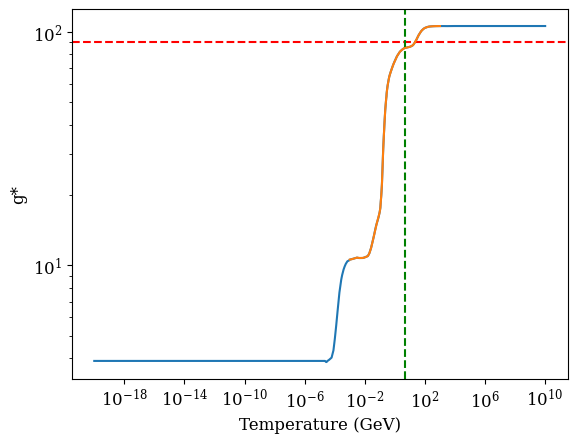

In [8]:
Mpl = 1.2209e19
GSTAR = 90.0
GSTAR_S = 90.0

path = "/Users/charlottemyers/projects/ctp/heffBW.dat"
data = np.loadtxt(path)
T_data = data[:,0]
g_eff = data[:,1]

m = 100.0  # DM mass in GeV
#plot
plt.plot(T_data, g_eff)
plt.xscale('log')
plt.yscale('log')
plt.axhline(y=GSTAR, color='r', linestyle='--')
# expected x of freeze out
plt.axvline(x=m/20, color='g', linestyle='--')

# define a function to return gstar at a given T
def gstar_interp(T):
    #if T < T_data.min() or T > T_data.max():
        #return GSTAR
    return np.interp(T, T_data, g_eff)

# plot outputs
T_test = np.logspace(-3, 3, 1000)
gstar_test = [gstar_interp(T) for T in T_test]
plt.plot(T_test, gstar_test, label='Interpolated g*')
plt.xlabel('Temperature (GeV)')
plt.ylabel('g*')

In [ ]:
# # Solve coupled boltzmann system for two species

# sigmav_AA_xx = 1e-9  # cm^3/s
# sigmav_xx_ff = 1e-9  # cm^3/s
# sigmav_deltaE = 1e-9  # cm^3/s

# # define dark photon and DM masses
# mA = 12.0  # GeV
# mchi = 120 # GeV
# Mpl = 1.2209e19
# GCHI = 2


# def H_of_T(T, time_dep_gstar = False):
#     if time_dep_gstar:
#         gstar = gstar_interp(T)
#     else:
#         gstar = GSTAR
#     return np.sqrt(8.0*np.pi**3/90.0 * gstar * T**2 / Mpl)

# def s_of_T(T, time_dep_gstar = False):   # uses g_{*s}(T)
#     if time_dep_gstar:
#         gstars = gstar_interp(T)
#     else:
#         gstars = GSTAR
#     return (2.0*np.pi**2/45.0) * gstars(T) * T**3





# def dln_gstars_dlnT(T, delta=1e-5):
#     """Numerical derivative of ln(g*_s) w.r.t. ln(T)."""
#     gstar_plus = gstar_interp(T * (1.0 + delta))
#     gstar_minus = gstar_interp(T * (1.0 - delta))
#     return (np.log(gstar_plus) - np.log(gstar_minus)) / (2.0 * np.log(1.0 + delta))

# def C_of_T(T):   # 1 - (1/3) d ln g*_s / d ln T
#     return 1.0 - (1.0/3.0) * dln_gstars_dlnT(T)

# def n_eq_species(m, g, Tspec):
#     x = m / Tspec
#     return g * (m*m*Tspec)/(2.0*np.pi**2) * kv(2, x)

# def rhs_n(x, y):
#     nchi, nA0 = y
#     T  = mchi / x
#     Th = xi_of_T(T) * T

#     H  = H_total(T, Th)
#     neq_chi = n_eq_species(mchi, GCHI, Th)
#     neq_A0  = n_eq_species(mA0,  gA0,  Th)

#     sv_chi = sigmav_chichi_to_SM(Th)   # or constant; HS-averaged
#     sv_AA  = sigmav_AA_to_chichi(Th)   # HS-averaged

#     C  = corr_SM(T)

#     term_SM  = sv_chi * (nchi**2 - neq_chi**2)
#     term_AA  = sv_AA  * (nA0**2  - (neq_A0**2 / neq_chi**2) * nchi**2)

#     dnchi_dx = ( -3.0*nchi/x - (term_SM - term_AA)/(H*x) ) * C
#     dnA0_dx  = ( -3.0*nA0/x - (term_AA)/(H*x) ) * C

#     # if Gamma_A0 > 0.0:
#     #     nA0_eq_decay = n_eq_species(mA0, gA0, T)
#     #     dnA0_dx += -(Gamma_A0/(H*x)) * (nA0 - nA0_eq_decay) * C

#     return np.array([dnchi_dx, dnA0_dx])


In [69]:
#####
# CONSTANTS
#######
# ----------------------------
# Constant values
# ----------------------------
GSTAR = 90.0 # constant default
GSTAR_S = 90.0 # constant default
ME = 0.000511e-3  # GeV
ALPHA_EM = 1.0/137.0
MPL   = 1.2209e19      # GeV
INCLUDE_HS_IN_H = True

# --- unit conversions: cm^3/s -> GeV^-2 ---
cm_to_GeV_inv = 5.0677307e13
s_to_GeV_inv  = 1.5192674e24
cm3s_to_GeV2  = (cm_to_GeV_inv**3) / s_to_GeV_inv
Gev2_to_cm3s = 1.0 / cm3s_to_GeV2

In [ ]:
#####
# Model parameters and functions
#######

# ----------------------------
# Functions for cross sections
# ----------------------------
def gD_of_alpha(alphaD):           # g_D from alpha_D
    return np.sqrt(4.0*np.pi*alphaD)

def sigmav_chichi_ee(epsilon, alphaD, mchi, mAp):
    """Zeroed if kinematically forbidden (mchi < me).
    """
    if mchi <= ME:
        return 0.0
    r   = mAp / mchi
    e2  = 4.0*np.pi*ALPHA_EM
    gD  = gD_of_alpha(alphaD)
    pref = 4.0 * e2 * (epsilon**2) * (gD**2)
    num  = (2.0 + (ME**2)/(mchi**2))
    den  = (r**2 - 4.0)**2
    thr  = np.sqrt(1.0 - (ME**2)/(mchi**2)) / (8.0*np.pi*mchi**2)
    return pref * (num/den) * thr

def sigmav_AA_chichi(alphaD, mchi, mA):
    #print("HERE")
    r = mA / mchi
    # if r < 1.0:
    #     return 0.0
    gD = gD_of_alpha(alphaD)
    pref = 32.0 * (gD**4) * (r**4 - 1.0) / (9.0 * r**4)
    thr  = np.sqrt(r**2 - 1.0) / (8.0*np.pi * (r**3) * mchi**2)
    return pref * thr

# def sigmav_chichi_AA(alphaD, mchi, mA):
#     return 4*np.pi *alphaD**2 / mchi *(mchi**2 - mA**2)**(3/2) / (2*mchi**2 - mA**2)**2



def sigmav_deltaE(alphaD, epsilon, r, x, TSM, Th):
    """elastic scattering xsec'"""
    term1 = (8/np.pi)*ALPHA_EM*alphaD*epsilon**2/(r**4 * x**6)
    term2 = factorial(6)*(1 - 2**(-5))*zeta(6)*(Th - TSM)
    return term1 * term2
# ----------------------------

# ----------------------------
# Model parameters
# ----------------------------

mchi  = 10      # GeV
mA   = 11   # GeV

alphaD = 1e-9
epsilon = 1e-7

gchi  = 2.0       # 2 dof
gA   = 3.0        # 3 dof

# ----------------------------

sv_xxff = sigmav_chichi_ee(epsilon, alphaD, mA, mchi)
sv_AAxx = sigmav_AA_chichi(alphaD, mchi, mA)
#sv_xxAA = sigmav_chichi_AA(alphaD, mchi, mA)
print("sigmav_xxff = ", sv_xxff , " cm^3/s")
print("sigmav_AAxx = ", sv_AAxx , " cm^3/s")

# ----------------------------
# convert units =
sv_xxff *= cm3s_to_GeV2
sv_AAxx *= cm3s_to_GeV2
#sv_xxAA *= cm3s_to_GeV2
print("sigmav_xxff = ", sv_xxff , " GeV^-2")
print("sigmav_AAxx = ", sv_AAxx , " GeV^-2")

sigmav_xxff =  3.0107327710326443e-27  cm^3/s
sigmav_AAxx =  2.4381462729685965e-20  cm^3/s
sigmav_xxff =  2.579161728817675e-10  GeV^-2
sigmav_AAxx =  0.002088652176972592  GeV^-2


In [188]:
# checking that formula agrees with g(r), from 2011.01240
gr = 4.44
print(alphaD**2 / mchi**2 * gr)

print(Gev2_to_cm3s * 1e-8)

4.440000000000001e-22
1.1673299651560847e-25


In [ ]:
# ----------------------------
# Entropy functions
# ----------------------------
def gstar_SM(T, t_dep = False):
    # if t_dep:
    #     gstar_s = gstar_interp(T)
    # else:
    #     gstar_s = GSTAR_S
    # return  gstar_s
    return GSTAR

def gstars_SM(T, t_dep = False):
    #return gstar_SM(T, t_dep)
    return GSTAR_S

def dln_gstars_SM_dlnT(T):
    return 0.0
# def dln_gstars_SM_dlnT(T, delta=1e-5):
#     """Numerical derivative of ln(g*_s) w.r.t. ln(T)."""
#     gstar_plus = gstar_interp(T * (1.0 + delta))
#     gstar_minus = gstar_interp(T * (1.0 - delta))
#     return (np.log(gstar_plus) - np.log(gstar_minus)) / (2.0 * np.log(1.0 + delta))


# ----------------------------
# Helper thermo stuff
# ----------------------------
def H_of_T(T, rho_h=0.0, t_dep = False):
    """Hubble from SM  + HS (if specified)."""
    rho_SM = (np.pi**2/30.0) * gstar_SM(T, t_dep) * T**4
    if INCLUDE_HS_IN_H:
        rho_tot = rho_SM + rho_h
    else:
        rho_tot = rho_SM
    return np.sqrt((8.0*np.pi/3.0) * rho_tot) / MPL

def s_SM(T, time_dep = True):
    """SM entropy density"""
    return (2.0*np.pi**2/45.0) * gstars_SM(T, time_dep) * T**3

def dx_dt(T, m = mchi):
    """dx/dt for x = mchi / T."""
    corr = 1.0 + (1.0/3.0) * dln_gstars_SM_dlnT(T)
    return H_of_T(T) * (m/T) / corr

def neq(m, g, T):
    """equilibrium number density at temperature T - use bessels"""
    x = m / T
    return g * (m**2*T) / (2.0*np.pi**2) * kv(2, x)

def n_rel_fermion_FD(T, g_f):
    """FD number density for relativistic fermions at SM T (e±: g_f=4)."""
    return (3.0 * float(zeta(3)) / (4.0 * np.pi**2)) * g_f * T**3

# # Hidden-sector (assumed nonrel.regime )
# def rho_h(nchi, nA, Th):
#     # rho_i ~ m_i n_i + 3/2 n_i Th
#     return mchi*nchi + mA*nA + 1.5*(nchi + nA)*Th

def rho_i_exact(n_i, m_i, Th):
    # source: 2504.00077, eqn 2.15
    z = m_i / Th
    # per-particle energy: m_i K1(z)/K2(z) + 3 Th (mass + kinetic)
    return n_i * (m_i * kv(1, z) / kv(2, z) + 3.0 * Th)

def P_i_exact(n_i, Th):
    # source: 2504.00077, eqn 2.15
    # MB equation of state is ideal-gas exactly: P = n T
    return n_i * Th

# def P_h(nchi, nA, Th):
#     return P_i_exact(nchi, Th) + P_i_exact(nA, Th)


# def Q_elastic(T, Th, nchi, nf, alphaD, epsilon, mA, mchi):
#     sigmav = sigmav_deltaE(alphaD, epsilon, mA/mchi, mchi/T, T, Th)
#     return -sigmav*nf*nchi
#     #return 0.0  # placeholder for now


# ----------------------------
# Collision terms
# ----------------------------
def collisions(params, nchi, gchi, nA, T, Th):
    # equilibrium distributions:

    alphaD = params["alphaD"]
    epsilon = params["epsilon"]
    sv_xx = params["sv_xxff"]
    sv_AA = params["sv_AAxx"]
    mchi = params["mchi"]
    mA = params["mA"]
    gA = params["gA"]
    gchi = params["gchi"]

    nchi_eq_SM = neq(mchi, gchi, T)
    nA_eq_Th  = neq(mA,  gA,  Th)
    nchi_eq_Th = neq(mchi, gchi, Th)


    # number collision terms:
    C_chi = -0.5 * sv_xx * (nchi**2 - nchi_eq_SM**2) \
            +      sv_AA * (nA**2  - (nA_eq_Th**2 / nchi_eq_Th**2) * nchi**2)

    C_A  = -  sv_AA * (nA**2  - (nA_eq_Th**2 / nchi_eq_Th**2) * nchi**2) #
            #- Gamma_A * (nAp - neq(mA, gA, T))   # decay to SM bath (eq at T)

    ### elastic exchange terms
    #nf = neq(ME, 2.0, T) / (T**3/(2.0*np.pi**2))  # number density of e+e- in SM bath (2 dof)
    nf = n_rel_fermion_FD(T, 4.0)  # number density of e+e- in SM bath (2 dof)
    Q_el = 0 #-sigmav_deltaE(alphaD, epsilon, mA/mchi, mchi/T, T, Th)*nf*nchi
    # #  - A' decays:
    Q_ann = - 0.5 * mchi * sv_xx * (nchi**2 - nchi_eq_SM**2)
    #Q_dec = - mA * Gamma_A * (nAp - neq(mA, gA, T))

    Q_h =  Q_ann  + Q_el  ## + Q_dec idk maybe add this later
    return C_chi, C_A, Q_h

# ----------------------------
# x-domain RHS: d/dx = (1/(dx/dt)) d/dt
# ----------------------------
def rhs_x(x, y, params):
    """
    y = [nchi, nAp, Th]; x = mchi/T
    """

    mchi = params["mchi"]
    mA   = params["mA"]

    nchi, nA, Th = y
    T   = mchi / x

    # hidden-sector energy density (exact, non-rel)
    rho_h = rho_i_exact(nchi, mchi, Th) + rho_i_exact(nA, mA, Th)

    H    = H_of_T(T, rho_h if INCLUDE_HS_IN_H else 0.0)
    xdot = dx_dt(T)  # = H x / [1 + (1/3) d ln g_*s / d ln T]

    # collisions
    C_chi, C_A, Qh = collisions(params, nchi, gchi, nA, T, Th)

    # time derivatives of number densities:
    dnchi_dt = -3.0 * H * nchi + C_chi     # boltzmann
    dnA_dt  = -3.0 * H * nA  + C_A         # boltzmann

    # HS energy/pressure and their time derivative relation for Th:
    nh   = nchi + nA # total HS number density
    #rhoh = rho_h(nchi, nA, Th)
    #Ph   = P_h(nchi, nA, Th)
    Ph = P_i_exact(nchi, Th) + P_i_exact(nA, Th)

    dnh_dt = dnchi_dt + dnA_dt

    # Energy eqn: dot{rho_h} + 3H(rho_h+P_h) = Q_h
    # => (sum m_i dot n_i) + (3/2)(nh dot Th + Th dnh_dt) + 3H(rho_h+P_h) = Q_h
    # solve for dot Th:
    sum_m_dni = mchi*dnchi_dt + mA*dnA_dt
    dotTh = (2.0/(3.0*nh)) * (Qh - sum_m_dni
                              - 1.5*Th*dnh_dt #
                              - 3.0*H*(rho_h + Ph)) # energy lost by Hubble expansion

    # convert to x-derivatives
    dnchi_dx = dnchi_dt / xdot
    dnA_dx  = dnA_dt  / xdot
    dTh_dx   = dotTh    / xdot

    return np.array([dnchi_dx, dnA_dx, dTh_dx])

def rhs_logx(x, u, params):
    """
    log-space RHS:
      u = [ln n_chi, ln n_Ap, ln Th]. returns d/dx of those logs
    """
    ln_nchi, ln_nA, ln_Th = u
    nchi = np.exp(ln_nchi)
    nA   = np.exp(ln_nA)
    Th   = np.exp(ln_Th)

    mchi = params["mchi"];  mA = params["mA"]
    T    = mchi / x

    # HS energy density and pressure
    rhoh = rho_i_exact(nchi, mchi, Th) + rho_i_exact(nA, mA, Th)
    Ph = P_i_exact(nchi, Th) + P_i_exact(nA, Th)

    # Hubble and x-dot
    H    = H_of_T(T, rhoh if INCLUDE_HS_IN_H else 0.0)
    xdot = dx_dt(T)

    # collisions (time-domain)
    C_chi, C_A, Qh = collisions(params, nchi, gchi, nA, T, Th)

    # Time derivatives for numbers
    dnchi_dt = -3.0 * H * nchi + C_chi
    dnA_dt   = -3.0 * H * nA   + C_A

    # Energy equation -> dTh/dt
    # n_h = nchi + nA, computed stably via logaddexp
    nh = np.exp(np.logaddexp(ln_nchi, ln_nA))
    dnh_dt = dnchi_dt + dnA_dt
    sum_m_dni = mchi*dnchi_dt + mA*dnA_dt
    # guard nh to avoid division by zero
    nh_safe = max(nh, 1e-300)
    dTh_dt = (2.0/(3.0*nh_safe)) * (Qh - sum_m_dni - 1.5*Th*dnh_dt - 3.0*H*(rhoh + Ph))

    # Convert to x-derivatives
    dnchi_dx = dnchi_dt / xdot
    dnA_dx   = dnA_dt   / xdot
    dTh_dx   = dTh_dt   / xdot

    # Return log-derivatives
    dln_nchi_dx = dnchi_dx / max(nchi, 1e-300)
    dln_nA_dx   = dnA_dx   / max(nA,   1e-300)
    dln_Th_dx   = dTh_dx   / max(Th,   1e-300)

    return np.array([dln_nchi_dx, dln_nA_dx, dln_Th_dx])


In [165]:
#
# ----------------------------
# Evolve function: integrate the system
# ----------------------------

def evolve(params, x_initial, x_final, y0, xs, log_space = False, time_dep_gstar =False):
    """Evolve the boltzmann eqn for given parameters"""
    if log_space:
        print("here")
        u0 = np.log(y0)
        sol = solve_ivp(rhs_logx, (x_initial, x_final), u0, args = (params,), t_eval=xs, method="Radau", rtol=1e-7, atol=1e-12) #, max_step=0.5)
    else:
        sol = solve_ivp(rhs_x, (x_initial, x_final), y0, args = (params,), t_eval=xs, method="Radau", rtol=1e-7, atol=1e-12, max_step=0.5)
    if not sol.success:
        raise RuntimeError(f"Integration failed: {sol.message}")
    x_arr = sol.t
    if log_space:
        sol.y = np.exp(sol.y)
    return {"sol": sol.y, "x_arr": x_arr}
    #"Y_arr": Y_arr, "s_arr": s_arr, "norm_Y_arr": norm_Y_arr}


def get_relic_abundance(Y, m):
    return 2.742e8 * m * Y

def Y(n, T): return n / s_SM(T)


In [185]:
# ----------------------------
# Set up the system
# ----------------------------

alpha = 1e-6
epsilon = 1e-5
mchi = 100
mA = 120
sv_AAxx = sigmav_AA_chichi(alpha, mchi, mA) #GeV^-2
sv_xxff = sigmav_chichi_ee(epsilon, alpha, mA, mchi) #GeV^-2


print(sv_AAxx)
print(sv_xxff)
params = {
    "mchi": mchi,
    "mA":   mA,
    "alphaD": alpha,
    "epsilon": epsilon,
    "sv_xxff": 1e-8,
    "sv_AAxx": 1e-8,
    #"sv_AAxx": sv_AAxx,
    #"sv_xxff": sv_xxff,
    "gchi": 2,
    "gA": 3,
}

x_i, x_f = 0.5, 1.0e3
T_i = mchi / x_i
Th_i = 0.5*T_i  # start with HS in kinetic eq. with SM (Th = T)
nchi_i = neq(mchi, gchi, T_i)
nA_i  = neq(mA,  gA,  T_i)
y0 = np.array([nchi_i, nA_i, Th_i]) #initial conditions
xs  = np.geomspace(x_i, x_f, 2000)

# sol = solve_ivp(rhs_x, (x_i, x_f), y0, args=(params,), t_eval=xs, method="Radau", rtol=1e-7, atol=1e-12)
# if not sol.success:
#     raise RuntimeError(sol.message)

# nchi, nAp, Th = sol.y
# T = mchi / xs


4.4400458613138774e-16
2.3318353126579804e-22


In [186]:
result = evolve(params, x_i, x_f, y0, xs, log_space = True)
nchi_evolve, nA_evolve, Th_evolve = result["sol"]
x_evolve = result["x_arr"]
T_evolve = mchi / x_evolve

here


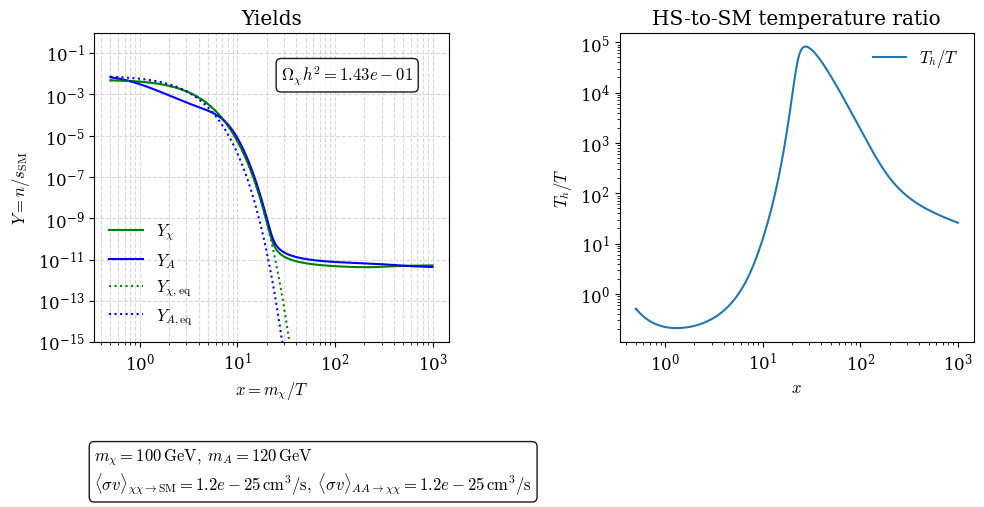

In [ ]:
# Diagnostics: yields vs SM entropy
mchi = params["mchi"]
T = mchi/xs
Th = Th_evolve
Ychi = Y(nchi_evolve, T)
YA  = Y(nA_evolve,  T)
xs = x_evolve
Omega_h2 = get_relic_abundance(Ychi[-1], mchi)

Ychi_eq = Y(neq(mchi, gchi, T), T)
YAp_eq  = Y(neq(mA,  gA,  T), T)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].loglog(xs, Ychi, color = "green", label=r'$Y_\chi$')
ax[0].loglog(xs, YA, color = "blue", label=r'$Y_{A}$')

# plot equilibrium yields for comparison
ax[0].loglog(xs, Ychi_eq, ':',  color = "green", label=r'$Y_{\chi,{\rm eq}}$')
ax[0].loglog(xs, YAp_eq,  ':', color = "blue", label=r'$Y_{A,{\rm eq}}$')
ax[0].set_ylim(1e-15, 1e0)

ax[0].set_xlabel(r'$x=m_\chi/T$'); ax[0].set_ylabel(r'$Y=n/s_{\rm SM}$'); ax[0].legend(frameon=False)
ax[0].set_title('Yields')

# add text annotation for model parameters
param_text = (
    r"$m_\chi = %.0f\,\mathrm{GeV},\; m_{A} = %.0f\,\mathrm{GeV}$" "\n"
    #r"$\alpha_D = %.1e,\; \epsilon = %.1e$" "\n"
    r"$\langle\sigma v\rangle_{\chi\chi\to\mathrm{SM}} = %.1e\,\mathrm{cm^3/s},\; "
    r"\langle\sigma v\rangle_{A A\to\chi\chi} = %.1e\,\mathrm{cm^3/s}$"
) % (params["mchi"], params["mA"],
     #params["alphaD"], params["epsilon"],
     params["sv_xxff"] * Gev2_to_cm3s, params["sv_AAxx"]* Gev2_to_cm3s)
ax[0].text(
    0.0,-0.5, param_text,
    transform=ax[0].transAxes,
    va='bottom', ha='left',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
    clip_on=False)

# add text annotation for relic abundance
relic_text = r"$\Omega_\chi h^2 = %.2e$" % (Omega_h2)
ax[0].text(
    0.9,0.9, relic_text,
    transform=ax[0].transAxes,
    va='top', ha='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
    clip_on=False)

ax[0].grid(True, which='both', ls='--', alpha=0.5)


ax[1].loglog(xs, Th/T, label=r'$T_h/T$')
ax[1].set_xlabel(r'$x$'); ax[1].set_ylabel(r'$T_h/T$'); ax[1].legend(frameon=False)
ax[1].set_title('HS-to-SM temperature ratio')



plt.tight_layout()
plt.show()

In [270]:
result_Q0 = evolve(params, x_i, x_f, y0, xs, log_space = True)
nchi_evolve, nA_evolve, Th_evolve = result["sol"]
x_evolve = result["x_arr"]
T_evolve = mchi / x_evolve

here


In [ ]:
# # plot a comparison
# # # solve with evolve method
# result = evolve(params, x_i, x_f, y0, xs)
# result_log = evolve(params, x_i, x_f, y0, xs, log_space = True)

# nchi_evolve, nA_evolve, Th_evolve = result["sol"]
# x_evolve = result["x_arr"]
# T_evolve = mchi / x_evolve

# nchi_log, nA_log, Th_log = result_log["sol"]
# x_log = result_log["x_arr"]
# T_log = mchi / x_log


# Ychi = nchi_evolve/ s_SM(mchi/x_evolve)
# YAp  = nA_evolve / s_SM(mchi/x_evolve)

# Ychi_log = nchi_log/ s_SM(mchi/x_log)
# YAp_log  = nA_log / s_SM(mchi/x_log)
# # plot comoving number densities



# plt.figure(figsize=(8,6))
# plt.loglog(x_evolve, Ychi, label=r'$Y_\chi$', color='blue')
# plt.loglog(x_evolve, YAp, label=r'$Y_{A^\prime}$', color='orange')

# plt.loglog(x_log, Ychi_log, '--', label=r'$Y_\chi$ (log-space)', color='blue')
# plt.loglog(x_log, YAp_log, '--', label=r'$Y_{A^\prime}$ (log-space)', color='orange')

# plt.xlabel(r'$x = m_\chi / T$')
# plt.ylabel(r'Comoving number density $Y$')
# plt.legend()
# plt.title("A Sanity Check: Comparing log-space and normal integration")
# plt.xscale('log')
# plt.yscale('log')

/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_7196/32340050.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ":" (-> linestyle=':'). The keyword argument will take precedence.
  ax[0].loglog(xs, Ychi_eq, ":", color=c, alpha=0.6, label=rf"$Y_x(eq)$", ls = "--")


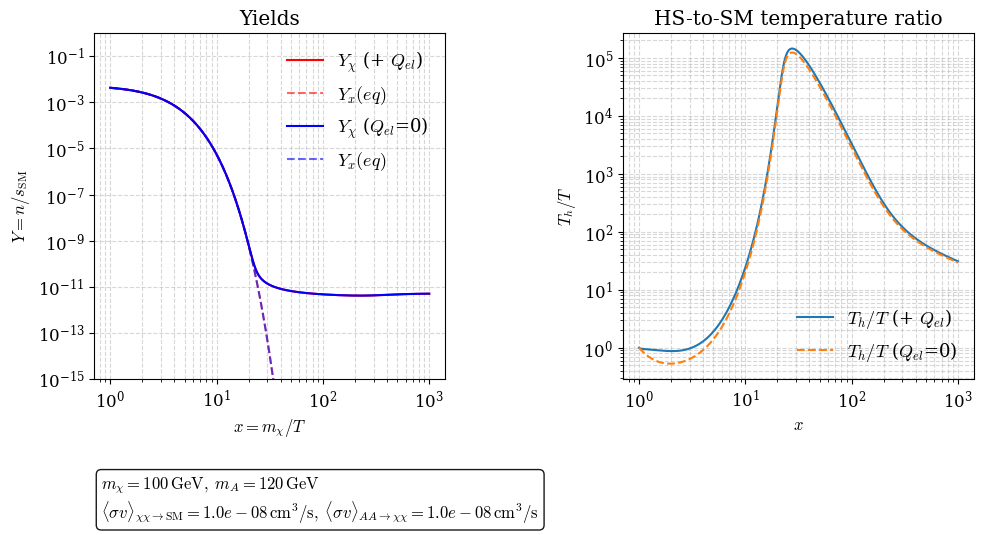

In [ ]:


runs = [ { "params":params, "result": result, "label": "+ $Q_{el}$", "color" : "red" },
         { "params":params, "result": result_Q0, "label": "$Q_{el}$=0", "color": "blue"} ]

# --- CONFIG ---
ylims = (1e-15, 1e0)
show_eq = True
show_param_box_first = True
show_relic_boxes = True

# --- STYLE ---
ls_cycle = cycle(['-', '--', '-.', ':'])
col_chi, col_A = "green", "blue"

fig, ax = plt.subplots(1, 2, figsize=(10, 6))

for i, run in enumerate(runs):
    params = run["params"]
    mchi = float(params["mchi"])
    res = run["result"]
    nchi, nA, Th = res["sol"]
    x = res["x_arr"]
    T = mchi / x

    Ychi = Y(np.asarray(nchi), T)
    YA   = Y(np.asarray(nA),   T)

    lbl_run = run.get("label", f"run {i+1}")
    ls = next(ls_cycle)

    # --- Yields (per run) ---
    c = run.get("color", None)
    ax[0].loglog(xs, Ychi, color=c, label=rf"$Y_\chi$ ({lbl_run})", ls = "-")
    #ax[0].loglog(xs, YA,   ls=ls, color=col_A,  label=rf"$Y_A$ ({lbl_run})")

    # --- Equilibrium (optional) ---
    if show_eq:
        gchi = params.get("gchi", None)
        gA   = params.get("gA",   None)
        Ychi_eq = Y(neq(params["mchi"], gchi, T), T)
        YA_eq   = Y(neq(params["mA"],   gA,   T), T)
        ax[0].loglog(xs, Ychi_eq, ":", color=c, alpha=0.6, label=rf"$Y_x(eq)$", ls = "--")
        #ax[0].loglog(xs, YA_eq,   ":", color=col_A,  alpha=0.6, label=rf"$Y_A$")

    # --- Per-run relic abundance box (optional) ---
    if show_relic_boxes and ("Omega_h2" in run):
        relic_text = r"$\Omega_\chi h^2 = {:.2e}$".format(run["Omega_h2"])
        y_anchor = 0.92 - 0.08*(i % 6)  # stagger to avoid overlap
        ax[0].text(
            0.97, y_anchor, relic_text,
            transform=ax[0].transAxes, va='top', ha='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            clip_on=False
        )

    # --- Temperature ratio ---
    ax[1].loglog(xs, Th/T, ls=ls, label=rf"$T_h/T$ ({lbl_run})")

    if i == 0 and show_param_box_first:
        param_text = (
    r"$m_\chi = %.0f\,\mathrm{GeV},\; m_{A} = %.0f\,\mathrm{GeV}$" "\n"
    r" $\alpha_D = %.1e,\; \epsilon = %.1e$" "\n"
    r"$\langle\sigma v\rangle_{\chi\chi\to\mathrm{SM}} = %.1e\,\mathrm{cm^3/s},\; "
    r"\langle\sigma v\rangle_{A A\to\chi\chi} = %.1e\,\mathrm{cm^3/s}$"
) % (params["mchi"], params["mA"], params["alphaD"], params["epsilon"], params["sv_xxff"], params["sv_AAxx"])
        ax[0].text(
            0.02, -0.42, param_text,
            transform=ax[0].transAxes, va='bottom', ha='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            clip_on=False
        )

# --- Cosmetics ---
ax[0].set_ylim(*ylims)
ax[0].set_xlabel(r"$x = m_\chi/T$")
ax[0].set_ylabel(r"$Y = n/s_{\rm SM}$")
ax[0].set_title("Yields")
ax[0].grid(True, which='both', ls='--', alpha=0.5)

ax[1].set_xlabel(r"$x$")
ax[1].set_ylabel(r"$T_h/T$")
ax[1].set_title("HS-to-SM temperature ratio")
ax[1].grid(True, which='both', ls='--', alpha=0.5)

ax[0].legend(frameon=False, fontsize=13, ncol=1)
ax[1].legend(frameon=False, fontsize=13, ncol=1)


# for axi in ax:
#     h, l = axi.get_legend_handles_labels()
#     seen, uh, ul = set(), [], []
#     for hi, li in zip(h, l):
#         if li not in seen:
#             seen.add(li); uh.append(hi); ul.append(li)
#     axi.legend(uh, ul, frameon=False, fontsize=9, ncol=1)

plt.tight_layout()
plt.show()


Relic abundance Omega h^2 = 1.401e-01


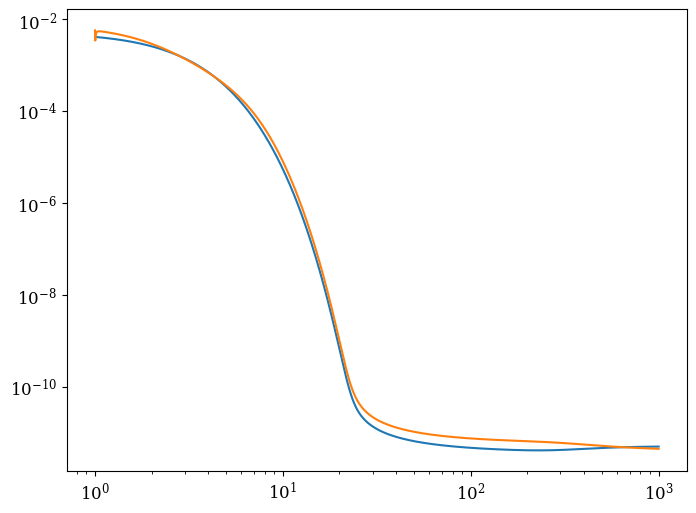

In [247]:
# plot
plt.figure(figsize=(8,6))
x_arr = result["x_arr"]
Ychi = nchi_evolve/ s_SM(mchi/x_arr)
YAp  = nA_evolve / s_SM(mchi/x_arr)

plt.loglog(x_arr, Ychi, label=r"$Y_\chi$")
plt.loglog(x_arr, YAp, label=r"$Y_{A'}$")

# get relic abundance
Omega_h2 = get_relic_abundance(Ychi[-1], mchi)
print(f"Relic abundance Omega h^2 = {Omega_h2:.3e}")

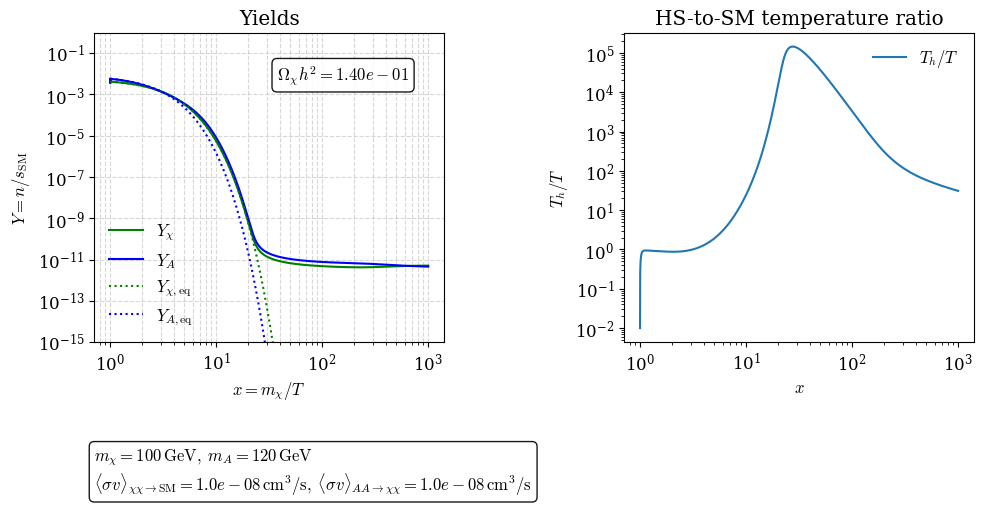

In [248]:
# Diagnostics: yields vs SM entropy
mchi = params["mchi"]
T = mchi/xs
Th = Th_evolve
Ychi = Y(nchi_evolve, T)
YA  = Y(nA_evolve,  T)
xs = x_evolve

Ychi_eq = Y(neq(mchi, gchi, T), T)
YAp_eq  = Y(neq(mA,  gA,  T), T)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].loglog(xs, Ychi, color = "green", label=r'$Y_\chi$')
ax[0].loglog(xs, YA, color = "blue", label=r'$Y_{A}$')

# plot equilibrium yields for comparison
ax[0].loglog(xs, Ychi_eq, ':',  color = "green", label=r'$Y_{\chi,{\rm eq}}$')
ax[0].loglog(xs, YAp_eq,  ':', color = "blue", label=r'$Y_{A,{\rm eq}}$')
ax[0].set_ylim(1e-15, 1e0)

ax[0].set_xlabel(r'$x=m_\chi/T$'); ax[0].set_ylabel(r'$Y=n/s_{\rm SM}$'); ax[0].legend(frameon=False)
ax[0].set_title('Yields')

# add text annotation for model parameters
param_text = (
    r"$m_\chi = %.0f\,\mathrm{GeV},\; m_{A} = %.0f\,\mathrm{GeV}$" "\n"
    r"$\langle\sigma v\rangle_{\chi\chi\to\mathrm{SM}} = %.1e\,\mathrm{cm^3/s},\; "
    r"\langle\sigma v\rangle_{A A\to\chi\chi} = %.1e\,\mathrm{cm^3/s}$"
) % (params["mchi"], params["mA"], params["sv_xxff"], params["sv_AAxx"])
ax[0].text(
    0.0,-0.5, param_text,
    transform=ax[0].transAxes,
    va='bottom', ha='left',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
    clip_on=False
)

# add text annotation for relic abundance
relic_text = r"$\Omega_\chi h^2 = %.2e$" % (Omega_h2)
ax[0].text(
    0.9,0.9, relic_text,
    transform=ax[0].transAxes,
    va='top', ha='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
    clip_on=False
)

ax[0].grid(True, which='both', ls='--', alpha=0.5)


ax[1].loglog(xs, Th/T, label=r'$T_h/T$')
ax[1].set_xlabel(r'$x$'); ax[1].set_ylabel(r'$T_h/T$'); ax[1].legend(frameon=False)
ax[1].set_title('HS-to-SM temperature ratio')



plt.tight_layout()
plt.show()